# Logistic regressions

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar_train = dict(npz_file.items())
print('It is a dictionary with keys:', list(cifar_train.keys()))
#cifar_train  

It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar_train['overfeat']
y = cifar_train['labels']
names = cifar_train['names']
pixels = cifar_train['pixels'].astype(np.float32)
pixels = pixels / 255

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)
print('pixels:', pixels.shape, pixels.dtype)
print('names:', names)

X: (5000, 4096) float32
y: (5000,) int64
pixels: (5000, 3072) float32
names: ['truck' 'car' 'airplane' 'ship']


In [3]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets
X_tr, X_te, y_tr, y_te, Pix_tr, Pix_te = train_test_split(
    X, y, pixels, train_size=4000, test_size=1000, random_state=0, stratify=y)
print('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)
print('Pixels set:', Pix_tr.shape, Pix_te.shape)

Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)
Pixels set: (4000, 3072) (1000, 3072)


In [4]:
# overfeat data: 176 values = 90% of the variance explained
from sklearn.preprocessing import StandardScaler
features=pd.DataFrame(X_tr) #convert to dataframe
# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_rescaled = scaler.fit_transform(X_tr)

# Create PCA transformer
pca_n = PCA(n_components=176)  #176 Components for Sum-PVE= 0.9001692523306701
#pca_n = PCA(n_components=408) # 408 Components for Sum-PVE= 0.9500094570539659

# Apply PCA to rescaled data
X_2d_rescaled = pca_n.fit_transform(X_rescaled)
X_2d_rescaled_df=pd.DataFrame(X_2d_rescaled)
#print(X_2d_rescaled_df.head())

# Create DataFrame with variance and principal components
results_df2 = pd.DataFrame.from_items([
    ('variance', X_rescaled.var(axis=0)),
    ('1st component', pca_n.components_[0]),
    ('2nd component', pca_n.components_[1]),
    ('3nd component', pca_n.components_[2])
]).set_index(features.columns)

# Sort DataFrame by the coefficients of the 1st loading vector
#results_df2.sort_values('1st component', ascending=False).head()

C:\Users\x\Anaconda3\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


# first task: 
Create a logistic regression classifier and tune the regularization strength.

In [5]:
# Split data into train/validation sets
X_tr2, X_valid2, y_tr2, y_valid2 = train_test_split(
    X_2d_rescaled_df, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)
print('Train set:', X_tr2.shape, y_tr2.shape)
print('Sub set:', X_valid2.shape, y_valid2.shape)

Train set: (3200, 176) (3200,)
Sub set: (800, 176) (800,)


In [6]:
#grid search with cross-validation
#fit a logistic regression with an L2 regularization term ???
#from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipe = Pipeline([
    ('scaler', None), # Optional step
    ('SDGClass', SGDClassifier())
])

# Create cross-validation object
grid_cv = GridSearchCV(pipe, [{
    'SDGClass__loss': ['log'],
    'SDGClass__max_iter': [1000],
    'SDGClass__tol': [1e-3],
    'SDGClass__random_state': [0],
    'SDGClass__alpha': [0.001, 0.01, 0.1]   
}], n_jobs=-1, cv=5)

# Fit estimator
grid_cv.fit(X_tr2, y_tr2)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('SDGClass', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'SDGClass__loss': ['log'], 'SDGClass__max_iter': [1000], 'SDGClass__tol': [0.001], 'SDGClass__random_state': [0], 'SDGClass__alpha': [0.001, 0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [7]:
# Collect results in a DataFrame
df = pd.DataFrame.from_items([    
    ('alpha', grid_cv.cv_results_['param_SDGClass__alpha']),
    ('mean accuracy', grid_cv.cv_results_['mean_test_score']),
    ('standard deviation', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean accuracy', ascending=False)

C:\Users\x\Anaconda3\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """


,alpha,mean accuracy,standard deviation
0,0.001,0.828438,0.018259
1,0.01,0.826562,0.019086
2,0.1,0.826250,0.018525


In [8]:
# Print maximum accuracy
idx = df['mean accuracy'].idxmax() # Index of maximum value
df1=df['mean accuracy']
max_accuracy = df1[idx]
df2=df['standard deviation']
df2_std = df2[idx]
df3=df['alpha']
df3_alpha = df3[idx]
print('Logistic regressions - top accuracy : {:.4f} (std: {:.4f}) alpha= {:.4f}'
      .format(max_accuracy, df2_std,df3_alpha))

Logistic regressions - top accuracy : 0.8284 (std: 0.0183) alpha= 0.0010


alpha= 0.0010

In [9]:
# Logistic regressions accuracy on full dataset
SGDClass_reg = SGDClassifier(loss='log',max_iter=1000, tol=1e-3, alpha=0.001,random_state=0)
SGDClass_reg.fit(X_tr, y_tr)
SGDClass_reg_score=SGDClass_reg.score(X_te, y_te)
print('Linear SVM accuracy (test set): ',SGDClass_reg_score)

Linear SVM accuracy (test set):  0.792


In [10]:
# Load data & Save Results
Result_df = pd.read_csv('Result_df.csv')
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.810
6          fc nn          0.839
7            cnn          0.816


In [11]:
Result_df.iloc[5,1]=SGDClass_reg_score
print(Result_df.head(9))
#Write Result as Dataframe to file
Result_df.to_csv('Result_df.csv', index=False, float_format='%.3f')

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.792
6          fc nn          0.839
7            cnn          0.816


# second task
Pick ten images from the test set and compute the probabilities for each class.

In [12]:
# Reshape images: 32 by 32 with 3 (RGB) color channels
Pix_tr_reshaped = Pix_tr.reshape(-1, 32, 32, 3)
Pix_te_reshaped = Pix_te.reshape(-1, 32, 32, 3)
print('pixels_reshaped:', Pix_tr_reshaped.shape, Pix_tr_reshaped.dtype)
print('pixels_reshaped:', Pix_te_reshaped.shape, Pix_te_reshaped.dtype)
#print(pixels_reshaped)

pixels_reshaped: (4000, 32, 32, 3) float32
pixels_reshaped: (1000, 32, 32, 3) float32


In [14]:
# Logistic regressions accuracy on full dataset
from sklearn.linear_model.stochastic_gradient import SGDClassifier
SGDClass_reg = SGDClassifier(loss='log',max_iter=1000, tol=1e-3, alpha=0.001, random_state=0)
SGDClass_reg.fit(X_tr, y_tr)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [51]:
result_predict=SGDClass_reg.predict_proba(X_te)

In [52]:
print(result_predict.shape)

(1000, 4)


[0.6769 0.007  0.007  0.309 ]


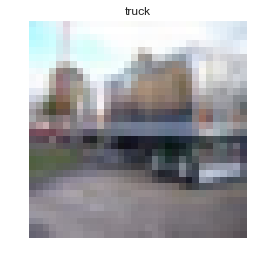

In [53]:
Num_Image=3
print(result_predict[Num_Image,:].round(4))
img=Pix_te_reshaped[Num_Image,:,:,:]
#print(img)
plt.imshow(img,cmap='gnuplot2')
plt.title("{}".format(names[y_te[Num_Image]]), fontsize=12)
plt.axis('off')
plt.show()

In [17]:
print('names:', names)

names: ['truck' 'car' 'airplane' 'ship']


In [54]:
result_predict_df= pd.DataFrame(result_predict).round(2)
result_predict_df.columns=['truck', 'car', 'airplane', 'ship']
result_predict_df.head(3)

,truck,car,airplane,ship
0,0.01,0.00,0.61,0.38
1,0.02,0.01,0.75,0.21
2,0.00,0.44,0.55,0.00


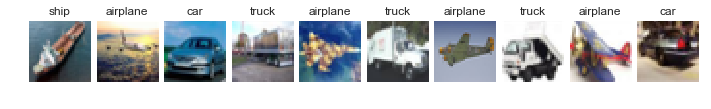

In [55]:
plt.figure( figsize=(12, 6))

for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    img=Pix_te_reshaped[i,:,:,:]
    plt.imshow(img, cmap='gnuplot2')
    plt.title("{}".format(names[y_te[i]]), fontsize=12)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [56]:
result_predict_df.head(10)

,truck,car,airplane,ship
0,0.01,0.00,0.61,0.38
1,0.02,0.01,0.75,0.21
2,0.00,0.44,0.55,0.00
3,0.68,0.01,0.01,0.31
4,0.01,0.00,0.65,0.34
5,0.91,0.07,0.00,0.01
6,0.28,0.00,0.63,0.09
7,0.92,0.03,0.05,0.00
8,0.68,0.31,0.01,0.00
9,0.02,0.96,0.02,0.00


# Third task
Try different regularization strengths. What is the effect on the probabilities?

Definition:
sklearn.linear_model.SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False, n_iter=None)

-> change alpha for different regularization strengths

In [21]:
df3_alpha

0.001

In [22]:
# Variants different regularization on Logistic regressions with full dataset
#alpha : float, Constant that multiplies the regularization term. 
SGDClass_reg = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=0.0001,random_state=0)
SGDClass_reg.fit(X_tr, y_tr)
SGDClass_reg_score=SGDClass_reg.score(X_te, y_te)
print('Linear SVM accuracy (test set): ',SGDClass_reg_score)

Linear SVM accuracy (test set):  0.811


-> Observation: worse accuracy 

In [23]:
#alpha : float, Constant that multiplies the regularization term. 
SGDClass_reg = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=0.01,random_state=0)
SGDClass_reg.fit(X_tr, y_tr)
SGDClass_reg_score=SGDClass_reg.score(X_te, y_te)
print('Linear SVM accuracy (test set): ',SGDClass_reg_score)

Linear SVM accuracy (test set):  0.81


In [24]:
#alpha : float, Constant that multiplies the regularization term. 
SGDClass_reg = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=0.1,random_state=0)
SGDClass_reg.fit(X_tr, y_tr)
SGDClass_reg_score=SGDClass_reg.score(X_te, y_te)
print('Linear SVM accuracy (test set): ',SGDClass_reg_score)

Linear SVM accuracy (test set):  0.833


-> Observation: Best accuracy 

In [26]:
#alpha : float, Constant that multiplies the regularization term. 
SGDClass_reg = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=0.2,random_state=0)
SGDClass_reg.fit(X_tr, y_tr)
SGDClass_reg_score=SGDClass_reg.score(X_te, y_te)
print('Linear SVM accuracy (test set): ',SGDClass_reg_score)

Linear SVM accuracy (test set):  0.821


In [27]:
#alpha : float, Constant that multiplies the regularization term. 
SGDClass_reg = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, alpha=1,random_state=0)
SGDClass_reg.fit(X_tr, y_tr)
SGDClass_reg_score=SGDClass_reg.score(X_te, y_te)
print('Linear SVM accuracy (test set): ',SGDClass_reg_score)

Linear SVM accuracy (test set):  0.822


In [28]:
# Logistic regressions accuracy on full dataset with optimized alpha
SGDClass_reg = SGDClassifier(loss='log',max_iter=1000, tol=1e-3, alpha=0.1,random_state=0)
SGDClass_reg.fit(X_tr, y_tr)
SGDClass_reg_score=SGDClass_reg.score(X_te, y_te)
print('Linear SVM accuracy (test set): ',SGDClass_reg_score)

# Load data & Save Results
Result_df = pd.read_csv('Result_df.csv')
print(Result_df.head(9))

Result_df.iloc[5,1]=SGDClass_reg_score
print(Result_df.head(9))
#Write Result as Dataframe to file
Result_df.to_csv('Result_df.csv', index=False, float_format='%.3f')

Linear SVM accuracy (test set):  0.833
           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.792
6          fc nn          0.839
7            cnn          0.816
           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.833
6          fc nn          0.839
7            cnn          0.816
